In [35]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2, read_atl03

In [3]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df_stats = pd.read_csv(out_path_csv)

In [42]:
df_stats = df_stats[df_stats.ice_sheet == 'AIS']

0 data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5 

68.63068076286308 -48.99488198077168
2019-06-17T06:45:13Z
ATL03_20190617064249_12220303_006_02.h5
1222
gt1l
  reading in data/atl03_raw/ATL03_20190617064249_12220303_006_02_gt1l_0001.h5
  reading in beam: gt1l  --> done.


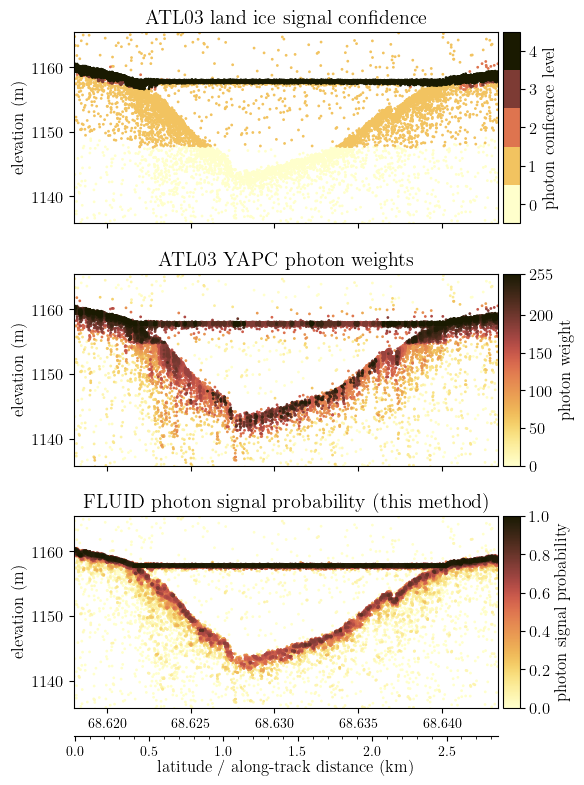

_____________________________________________________________

1 data/lakes/lake_07947542_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712181153_02240405_006_02_gt3l_0001.h5 

69.53422194822983 -49.120212248936795
2019-07-12T18:14:37Z
ATL03_20190712181153_02240405_006_02.h5
224
gt3l
  reading in data/atl03_raw/ATL03_20190712181153_02240405_006_02_gt3l_0001.h5
  reading in beam: gt3l  --> done.


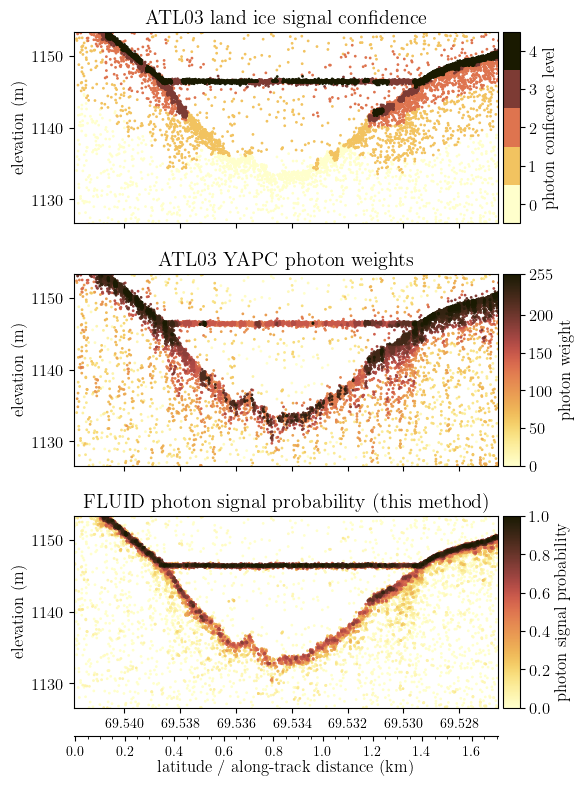

_____________________________________________________________

2 data/lakes/lake_09757904_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0054.h5 

-71.64274351030278 67.85854611024628
2019-01-02T18:48:55Z
ATL03_20190102184312_00810210_006_02.h5
81
gt2l
  reading in data/atl03_raw/ATL03_20190102184312_00810210_006_02_gt2l_0054.h5
  reading in beam: gt2l  --> done.


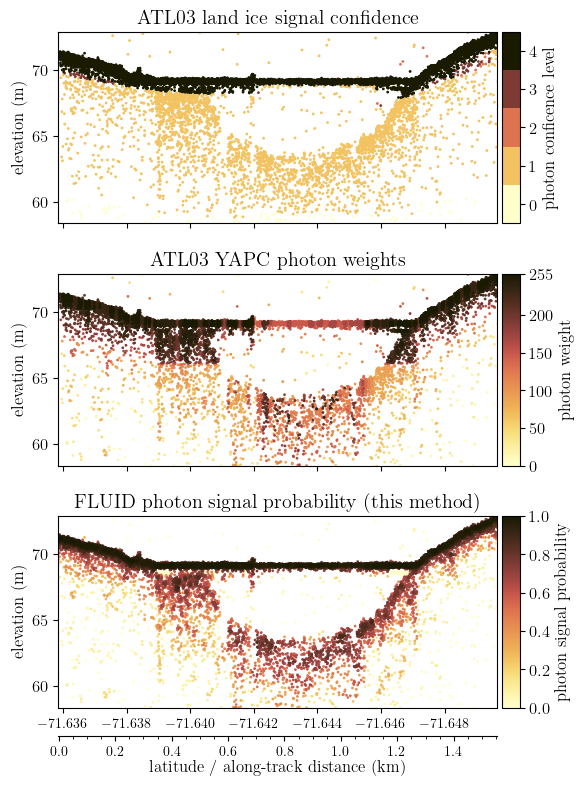

_____________________________________________________________

3 data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5 

-72.8859295027974 67.30819767218487
2019-01-02T18:49:15Z
ATL03_20190102184312_00810210_006_02.h5
81
gt2l
  reading in data/atl03_raw/ATL03_20190102184312_00810210_006_02_gt2l_0062.h5
  reading in beam: gt2l  --> done.


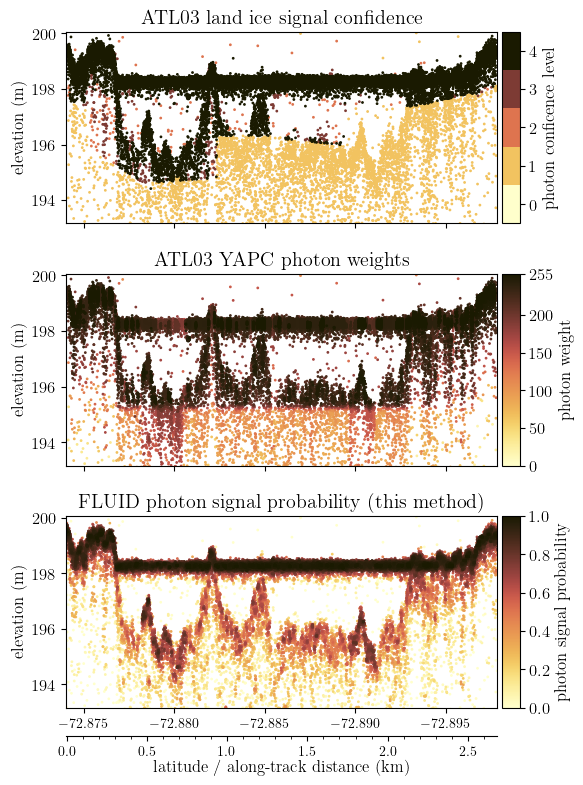

_____________________________________________________________



In [86]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
cmap_fig = cmc.lajolla

files = [
    # 'data/lakes/lake_04476359_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190716051841_02770403_006_02_gt1l_0000.h5',
    #'data/lakes/lake_06815846_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0007.h5',
    'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5',
    'data/lakes/lake_07947542_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712181153_02240405_006_02_gt3l_0001.h5',
    #'data/lakes/lake_08793839_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt2l_0019.h5',
    # 'data/lakes/lake_09008845_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt1l_0005.h5',
    #'data/lakes/lake_08858209_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190613065109_11610303_006_02_gt1l_0001.h5',
    'data/lakes/lake_09757904_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0054.h5',
    #'data/lakes/lake_09778059_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190123173555_04010210_006_02_gt3l_0022.h5',
    'data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5',
    #'data/lakes/lake_09981703_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190124062339_04090212_006_02_gt2l_0001.h5',   
]

start = 0
# end = 1
# files = np.array(df_stats.file_name)[start:end]

# files = np.array(df_stats.file_name)[[1]]

for i, fn in enumerate(files):

    print(start+i, fn[fn.find('data/lakes/lake_'):], '\n')
    
    # read in the melt lake data
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)
    
    df = lk.photon_data
    df_mframe = lk.mframe_data
    xatcmin = df.xatc.min()
    df.xatc -= xatcmin
    surf_elev = lk.surface_elevation
    latmin = df.lat.min()
    latmax = df.lat.max()
    lonmin = df.lon.min()
    lonmax = df.lon.max()
    thisdate = lk.time_utc[:10]
    rgt = lk.rgt
    gtx = lk.gtx

    # download ATL03 data from NSIDC
    atl03_dir = 'data/atl03_raw'
    fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
    if not os.path.isfile(fn_atl03):
        bbox = [lonmin, latmin, lonmax, latmax]
        granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
        for gran in granule_list:
            if lk.granule_id[:30] in gran:
                thisfile = atl03_dir + '/processed_' + gran
                break
        os.rename(thisfile, fn_atl03)

    # read in ATL03 data from NSIDC
    beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
    df03 = dfs[gtx]

    ylms = np.array((-2*lk.max_depth, 0.7*lk.max_depth)) + surf_elev
    xlms = (df.lat.min(), df.lat.max())

    fig, axs = plt.subplots(figsize=[6, 8], dpi=100, nrows=3, ncols=1, sharex=True)
    ax = axs[0]
    df_conf = df03.sort_values(by='conf')
    n_bins = 5
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_conf.lat, df_conf.h, s=1, alpha=1, c=df_conf.conf, cmap=thecmap, vmin=-0.5, vmax=4.5)
    ax.set_title('ATL03 land ice signal confidence')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon conficence level')

    ax = axs[1]
    df_yapc = df03.sort_values(by='weight_ph')
    n_bins = 255
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_yapc.lat, df_yapc.h, s=1, alpha=1, c=df_yapc.weight_ph, cmap=thecmap, vmin=0, vmax=255)
    ax.set_title('ATL03 YAPC photon weights')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical', ticks=[0, 50, 100, 150, 200, 255])
    cbar.set_label('photon weight')

    ax = axs[2]
    df_snr = df.sort_values(by='snr')
    n_bins = 1000
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_snr.lat, df_snr.h, s=1, alpha=1, c=df_snr.snr/df_snr.snr.max(), cmap=thecmap, vmin=0, vmax=1)
    ax.set_title('FLUID photon signal probability (this method)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon signal probability')
    
    for ax in axs.flatten():
        ax.set_xlim(xlms)
        ax.set_ylim(ylms)
        ax.set_ylabel('elevation (m)')

    axs[2].ticklabel_format(useOffset=False, style='plain')
    axs[2].tick_params(axis='x', labelsize=10)

    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # flip x-axis if track is descending, to make along-track distance go from left to right
    if gt.lat.iloc[0] > gt.lat.iloc[-1]:
        for axx in axs.flatten():
            axx.set_xlim(np.flip(np.array(xlms)))

    # add along-track distance
    lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    _lat = np.array(lx.lat)
    _xatc = np.array(lx.x10) / 1e3
    def lat2xatc(l):
        return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    def xatc2lat(x):
        return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
    secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    secax.tick_params(axis='both', which='major', labelsize=10)
    secax.ticklabel_format(useOffset=False, style='plain')
    
    fig.tight_layout()
    plt.savefig('plots/density_comparison_%i.jpg' % (i+1), dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')
